# CIFAR10 EDA

## Imports

In [6]:
import os
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from sklearn.decomposition import PCA
import joblib
from mltoolkit.utils import dump_keras_model,dump_arrays,dump_sklearn_model

In [275]:
def dump_arrays(dic:dict,path:str="Datasets\\Raw Data\\",fmt:str='csv',**kwargs):
    '''
    Dump multiple Series/DataFrames/nd-arrays as CSV/Parquet/Pickle format 
    at once.
    
    Parameters:
    ----------
    dic: dictionary
        Dictionary of the nd-arrays/Series/DataFrame to be dumped.
        Key = filename, Value = nd-arrays/Series/DataFrame
    path: str
        Path to dump the file(s)
    fmt: str {'csv','parquet','pkl'}
        File format to be stored.
    **kwargs
    '''
    try:
        os.mkdir(path)
    except:
        pass
    assert fmt in ('csv','parquet','pkl','pickle')
    
    for filename,file in dic.items():
        if fmt in ['csv','parquet']:
            if type(file) is np.ndarray or type(file) is pd.Series:
                file = pd.DataFrame(file)
            file.columns = [str(n) for n in file.columns.values]
            if fmt == 'csv': file.to_csv(path+filename+".csv",**kwargs)
            elif fmt == 'parquet': file.to_parquet(path+filename+".parquet",**kwargs)
        elif fmt == 'pkl' or 'pickle':
            joblib.dump(file,path+filename+".pkl",**kwargs)
        else:
            raise ValueError("Only {'csv','parquet','pkl'} file formats are supported")

In [1]:
def plot_class_images(X,y,samples=5,col_num=8,image_size=2):
    '''
    Plot random number of images from each class.
    Only for dataset containing images in grayscale pixel or RGB pixel.
    
    Parameters:
    ----------
    X: nd-array of images
        3d-array {shape=(a,b,c)}{0.0-1.0 or 0-255.0} for grayscale images and 
        4d-array {shape=(a,b,c,d)}{0.0-1.0 or 0-255.0} for color images.
    y: 1d-array or array or list
        Labels of the X dataset with same first dimension size.
    samples: int, Default = 5
        Number of random samples per class to show.
    col_num: int, Default = 8
        Number of images to show horizontally (display column length).
    image_size: int, Default = 2
        Size of the image (edge length).
    '''
    if type(X) is not np.ndarray:
        raise TypeError("Only 3d or 4d-arrays are supported.")
    if type(y) is pd.DataFrame or type(y) is pd.Series:
        if y.ndim == 1:
            y = y.values
        else:
            raise ValueError("Only 1 dimentional arrays are supported for labels dataset.")
    elif type(y) is not np.ndarray:
        raise TypeError("Only 1 dimentional arrays are supported for labels dataset.")
    
    axes_num =  np.unique(y).size * (samples+1)
    row_num = ceil(axes_num/col_num)
    cur_ax = 0
    fig,axs = plt.subplots(row_num,col_num,
                           figsize=(round(1.125*image_size*col_num),
                                    image_size*row_num),
                           tight_layout=True,facecolor='w')
    axs = axs.flat
    ax_black = np.zeros(X.shape[1:])

    for label in np.unique(y):
        mask = (y == label)
        images_of_label = X[mask]
        sample_mask = [np.random.randint(images_of_label.shape[0]) for i in range(samples)]
        images_of_label = images_of_label[sample_mask]

        axs[cur_ax].imshow(ax_black)
        axs[cur_ax].text(X.shape[1]/2,X.shape[2]/2,label,c='w',
                         size=40,ha='center',va='center_baseline')
        axs[cur_ax].set(xticks=[],yticks=[])
        cur_ax += 1

        for image in images_of_label:
            axs[cur_ax].imshow(image)
            axs[cur_ax].set(xticks=[],yticks=[])
            cur_ax += 1
    plt.show()

## Downloading the Datasets

In [2]:
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = cifar10.load_data()
X_train_raw.shape, y_train_raw.shape,X_test_raw.shape,y_test_raw.shape

170498071/170498071 [==============================] - 463s 3us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

Reshaping y datasets to 1 dimension.

In [6]:
y_train_raw = y_train_raw.flatten()
y_test_raw = y_test_raw.flatten()
y_train_raw.shape,y_test_raw.shape

((50000,), (10000,))

### Saving the datasets

In [68]:
raws = {
    "X_train_raw":X_train_raw,
    "y_train_raw":y_train_raw,
    "X_test_raw":X_test_raw,
    "y_test_raw":y_test_raw,
}
dump_arrays(raws,fmt='pkl',compress=9)

## Loading the Datasets

In [3]:
X_train_raw = joblib.load("Datasets\\Raw Data\\X_train_raw.pkl")
y_train_raw = joblib.load("Datasets\\Raw Data\\y_train_raw.pkl")
X_test_raw = joblib.load("Datasets\\Raw Data\\X_test_raw.pkl")
y_test_raw = joblib.load("Datasets\\Raw Data\\y_test_raw.pkl")

## First Insights

Here, we will display a few pictures for each class and try to gain some initial insights by directly looking at the visualization of the images.

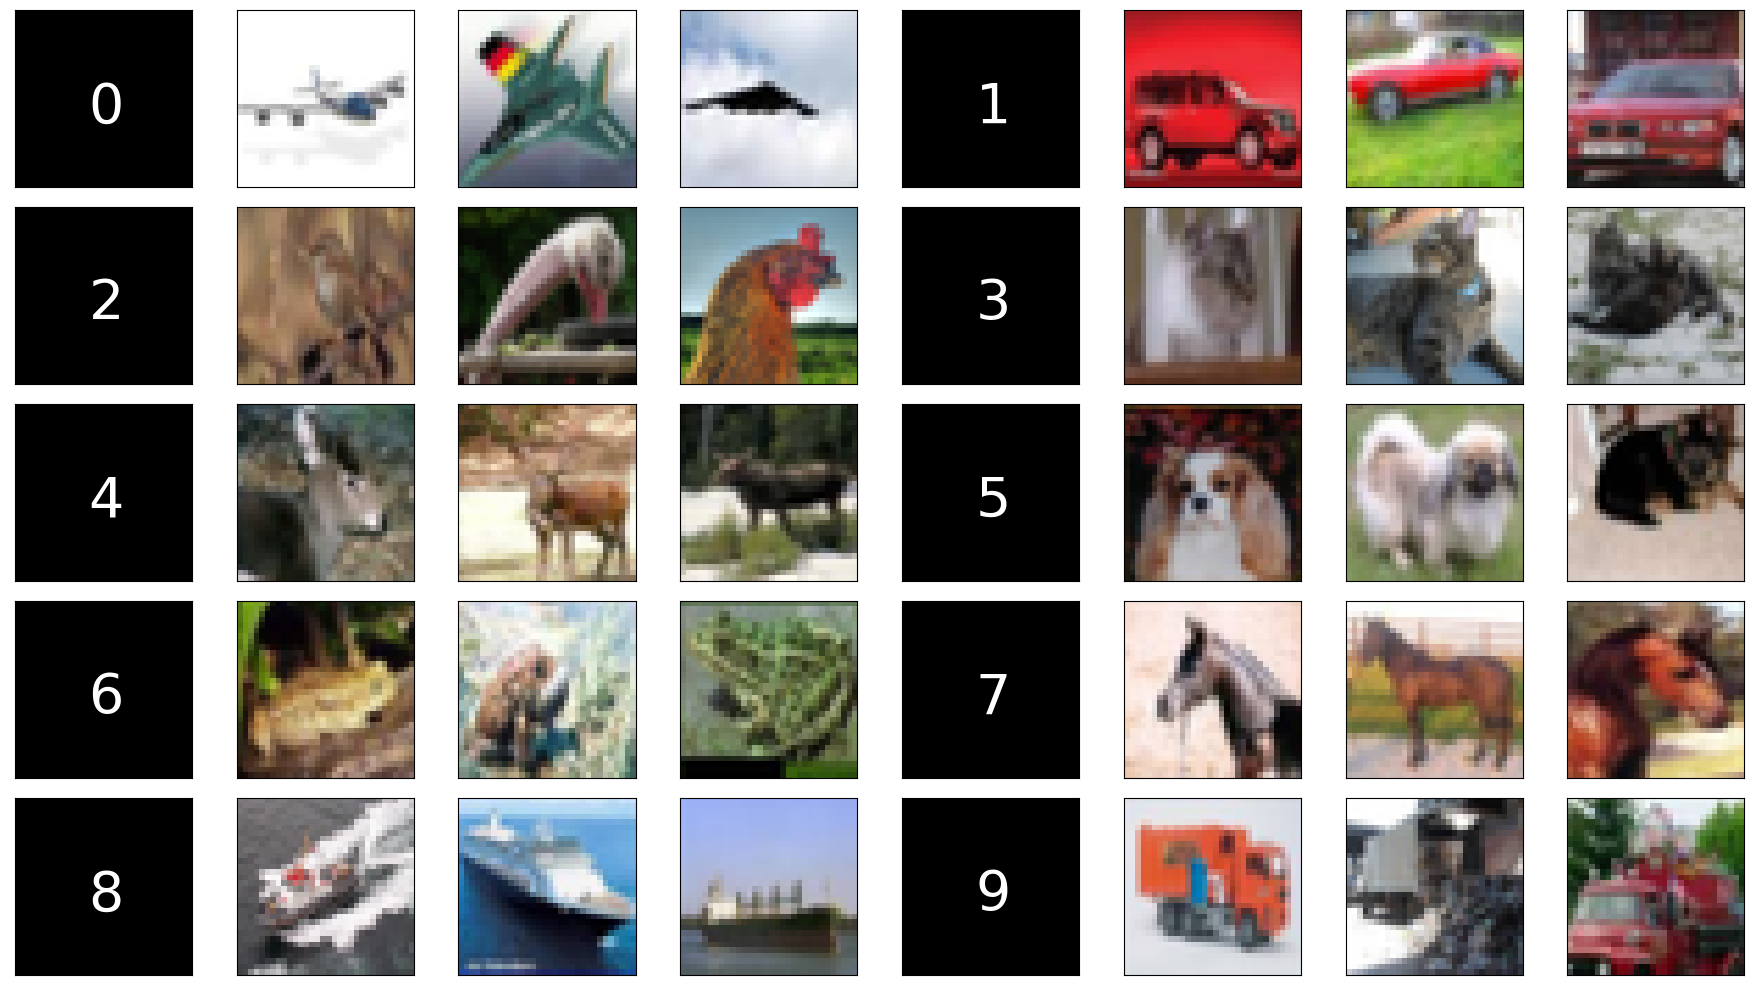

In [144]:
plot_class_images(X_train_raw,y_train_raw,3)

We can see that there are planes, cats, dogs, horses, ships, etc classes in our dataset.

## PCA

We will now try to use PCA to preprocess the datasets and hopefully we can reduce the dimensionality while preserving 99% of the image information.

In [208]:
def find_pca_components(X,n_components=500,step=200,confidence=0.99):
    X = X.copy()
    if X.ndim > 2: X = X.reshape(X.shape[0],-1)
    
    print(n_components,end='')
    pca = PCA(n_components).fit(X)
    if pca.explained_variance_ratio_.sum() > confidence:
        print(f'\nn_components(confidence={confidence}):',
              np.argmax(np.cumsum(pca.explained_variance_ratio_) > confidence))
        return pca
    else:
        print(',',end='')
        return find_pca_components(X,n_components=n_components+step,
                                   step=step,confidence=confidence)

In [221]:
X_train_raw_scaled = X_train_raw/255

In [222]:
pca = find_pca_components(X_train_raw_scaled,500,200)

500,700
n_components(confidence=0.99): 659


In [5]:
pca = PCA(700).fit(X_train_raw.reshape(50000,-1)/255)

In [271]:
X_train_trans = pca.transform(X_train_raw_scaled.reshape(50000,-1))
X_train_trans_inv = pca.inverse_transform(X_train_trans)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


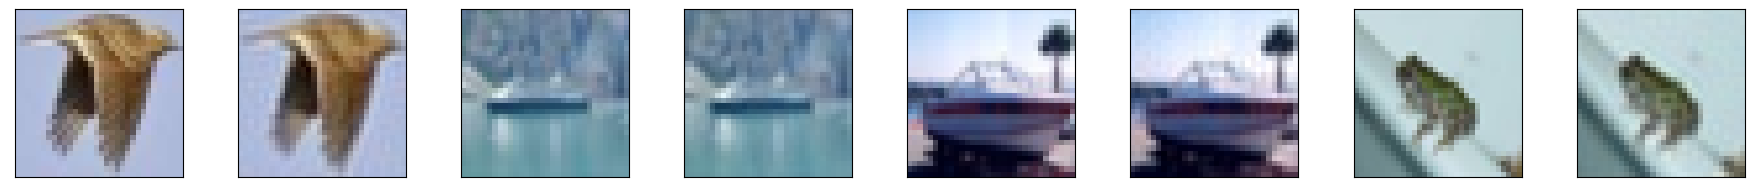

In [272]:
fig,axs = plt.subplots(1,8,figsize=(18,2),facecolor='w',tight_layout=True)
cur_ax = 0
for i in [123,456,6789,10111]:
    axs.flat[cur_ax].imshow(X_train_raw_scaled[i])
    cur_ax += 1
    axs.flat[cur_ax].imshow(X_train_trans_inv.reshape(50000,32,32,3)[i])
    cur_ax += 1
for ax in axs.flat:
    ax.set(xticks=[],yticks=[])
plt.show()

Althoug the images after PCA(700) preprocessing shows some sign of loss, but it still preserves well most of its content.\
We will stick with this unless necessary to change the n_components again.plot_class_images(X_train_raw,y_train_raw,3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

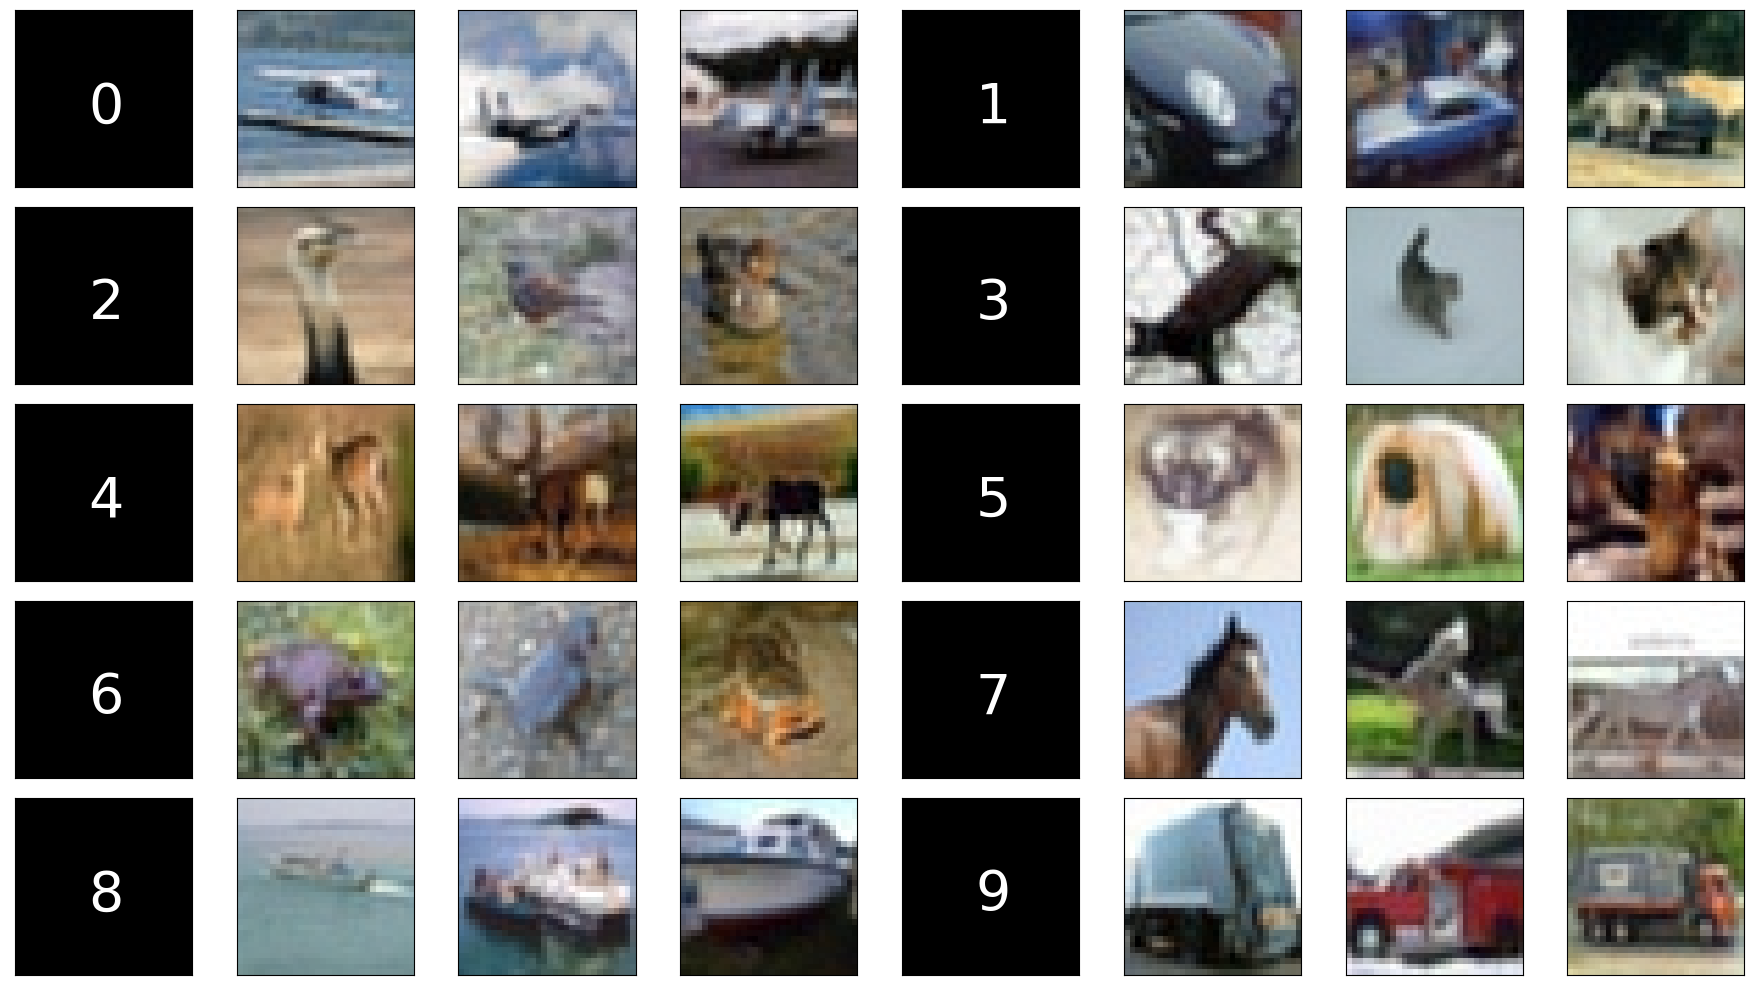

In [273]:
plot_class_images(X_train_trans_inv.reshape(50000,32,32,3),y_train_raw,3)

### Transforming test dataset

In [282]:
X_test_trans = pca.transform(X_test_raw.reshape(10000,-1)/255)

In [288]:
X_test_trans.shape

(10000, 700)

### Saving the Datasets

In [289]:
pcas = {
    "X_train_trans":X_train_trans,
    "X_test_trans":X_test_trans
}
dump_arrays(pcas,"Datasets\\",fmt='pkl')

### Saving the PCA transformer

In [7]:
dump_sklearn_model(pca,"Trained Models\\Transformers\\","PCA(700)",compress=9)